# Genesis4 Particles

This shows examples of the various ways to input particle data into Genesis4.

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
from genesis.version4 import Genesis4
from lume.tools import full_path
import os
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Lattice

Create a simple drift lattice

In [3]:
LATFILE = 'data/genesis4_drift.lat'

def make_lat():
    lat = f"""
D1: DRIFT = {{ l = 1}};
LAT: LINE= {{ D1 }};
    """
    with open(LATFILE, 'w') as f:
        f.write(lat)
    
make_lat()
!cat {LATFILE}


D1: DRIFT = { l = 1};
LAT: LINE= { D1 };
    

# `profile_file`

Make a simple current distribution:

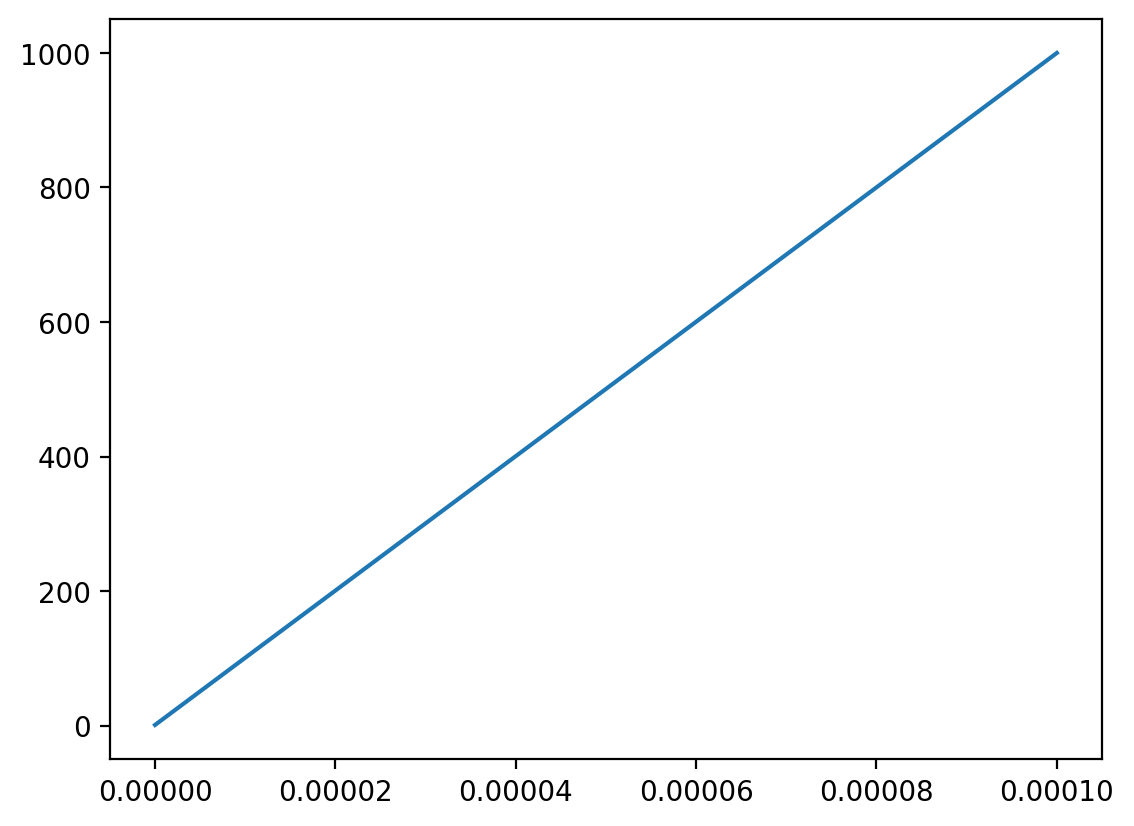

In [4]:
NPTS = 100
SLEN = 100e-6 
S = np.linspace(0, SLEN, NPTS)
CURRENT = np.linspace(1, 1000.0, NPTS)
plt.plot(S, CURRENT)

In [5]:
G = Genesis4()

INPUT0 = {'main': [{'type': 'setup',
   'rootname': 'drift_test',
   'lattice': full_path(LATFILE),
   'beamline': 'LAT',
   'lambda0': 100e-9,
   'gamma0': 1000,
   'delz': 0.026,
   'seed': 123456,
   'npart': 128},
  {'type': 'time', 'slen': SLEN, 'sample': 1},
 # {'type': 'field', 'dgrid': 0.0001, 'ngrid': 101, 'accumulate': True},
  {'type': 'profile_file',
   'label': 'beamcurrent',
   'xdata': S, 
   'ydata': CURRENT},
  {'type': 'beam',
   'current': '@beamcurrent',
   'gamma': 1000,
   'delgam': 1,
   'ex': 1e-6,
   'ey': 1e-6,
   'alphax': -0.7393217413918415,
   'betax': 7.910909406464387,
   'alphay': 1.3870723536888105,
   'betay': 16.881178621346898},
  {'type': 'track', 'zstop': 1},
  {'type':'write', 'beam':'end'},
                  ]}

G.input = INPUT0
G.verbose=True
G.run()

Configured to run in: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmp87igs9f3
Running Genesis4 in /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmp87igs9f3
/Users/chrisonian/Code/GitHub/Genesis-1.3-Version4/build/genesis4 genesis4.in
---------------------------------------------
GENESIS - Version 4.6.2 (beta) has started...
Compile info: Compiled by chrisonian at 2023-02-16 20:48:14 [UTC] from Git Commit ID: babc4431d0aba1ecdad371816418713fdff0af53
Starting Time: Mon Mar 20 08:37:54 2023

MPI-Comm Size: 1 nodes

Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Adding profile with label: beamcurrent
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 1000 slices for a time window of 100 microns
Initial analysis of electron beam and radiation field...
Writing output file...

Core Simulation done.
End of Track
Writing particle distribution to file: end.par.h5 ...

Program is terminating...
Ending Tim

Loaded particle data: 'end' as a ParticleGroup with 128000 particles


<ParticleGroup with 128000 particles at 0x138ca11c0>

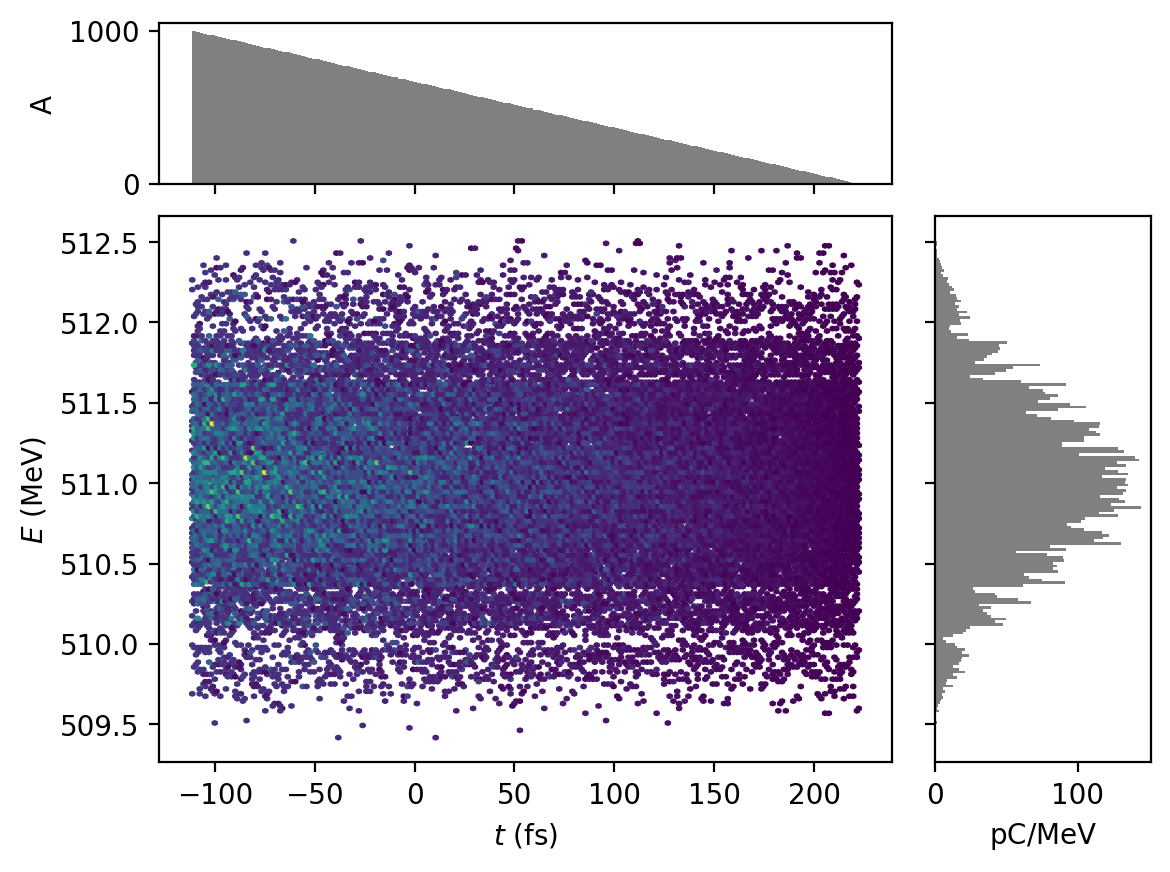

In [6]:
G.load_particles()
P1 = G.particles['end']
P1.drift_to_z()
P1.plot('t', 'energy')
P1

Resample particles for equal weights. This is neccessary when reading from a distribution file.

<ParticleGroup with 128000 particles at 0x139c832e0>

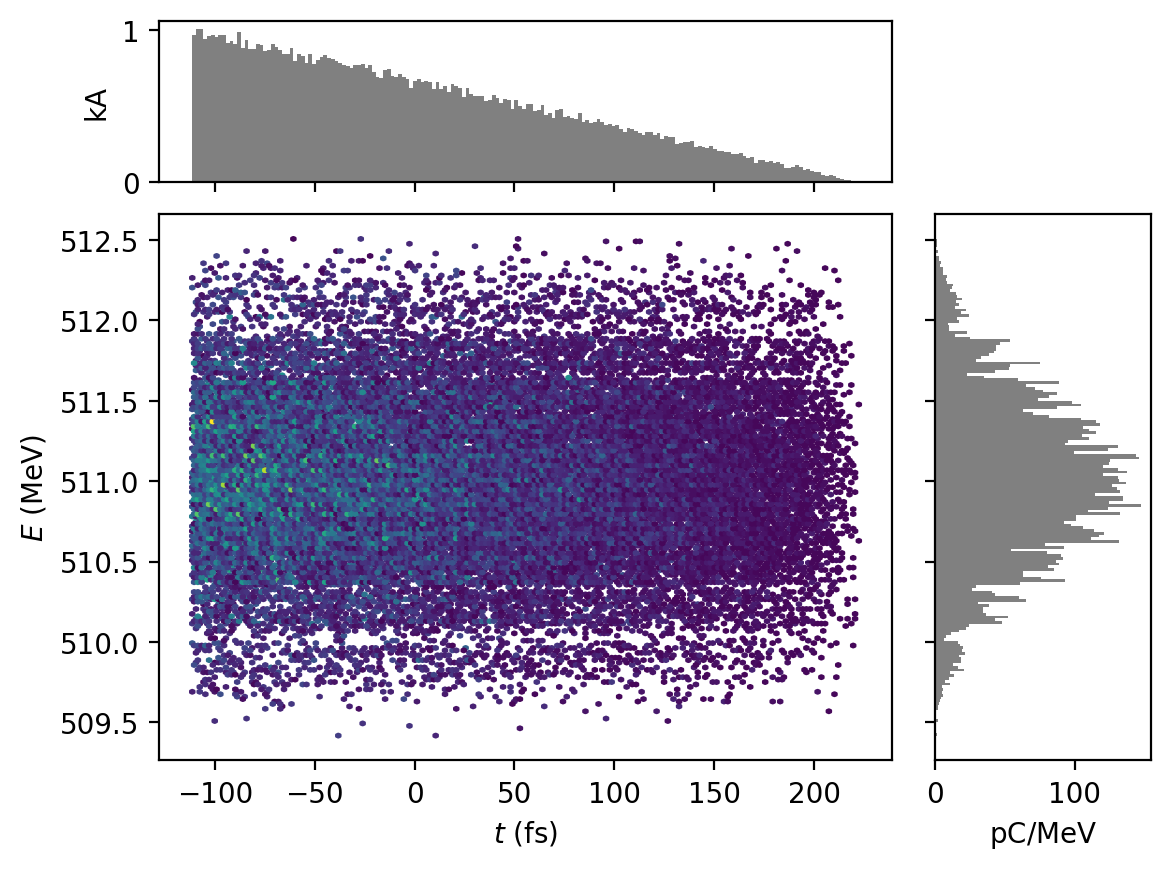

In [7]:
NSAMPLE = len(P1)
P1r = P1.resample(NSAMPLE)
P1r.plot('t', 'energy')
P1r

Make a more interesting distribution from this:

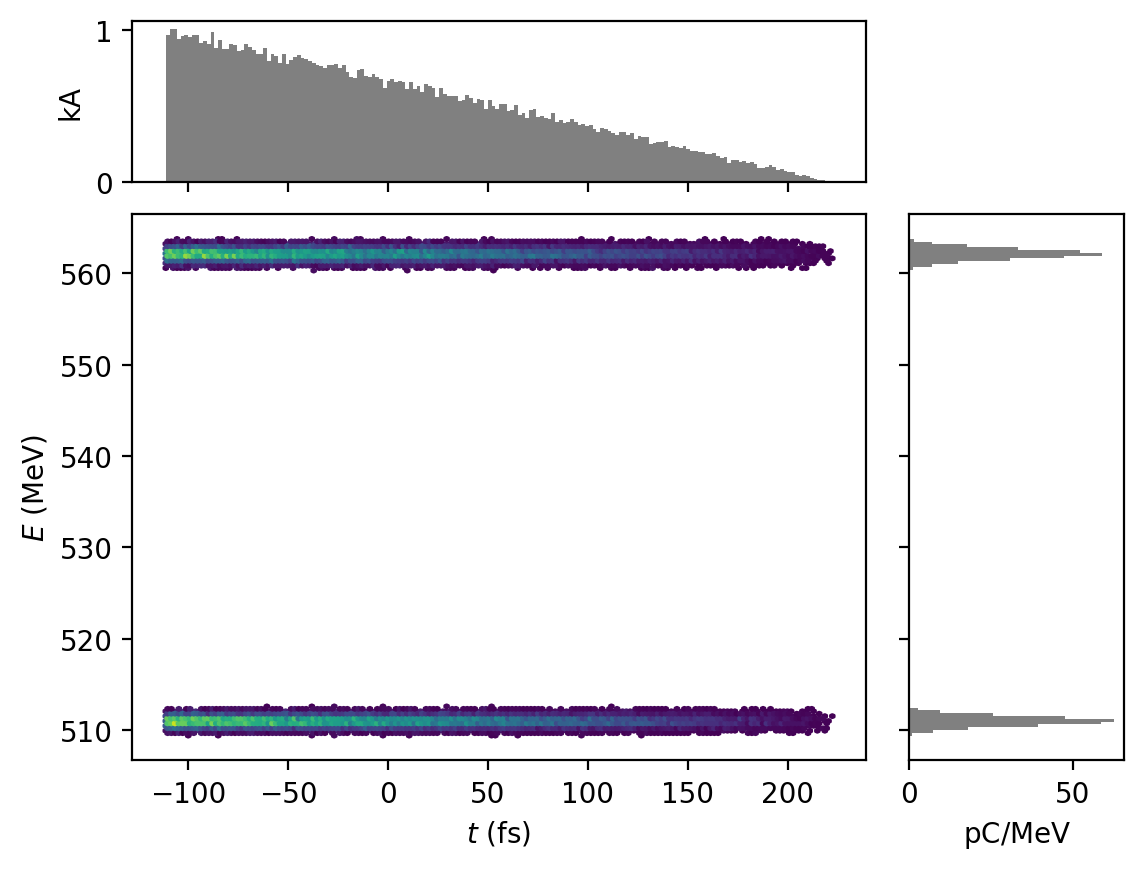

In [8]:
P1r.pz[0:len(P1)//2] *= 1.1
P1r.plot('t', 'energy')

ParticleGroup can write to a file for Genesis4.

In [9]:
DIST_FILE = 'genesis4_distribution.h5'
P1r.write_genesis4_distribution(DIST_FILE, verbose=True)

Datasets x, xp, y, yp, t, p written to: genesis4_distribution.h5


# importdistribution

Use this file as the input to a new simulation. 

When using `.initial_particles`, the appropriate input will be written automatically. 

In [10]:
G1 = Genesis4()

INPUT1 = {'main': [{'type': 'setup',
   'rootname': 'drift_test',
   'lattice': full_path(LATFILE),
   'beamline': 'LAT',
   'lambda0': 100e-9,
   'gamma0': 1000,
   'delz': 0.026,
   'seed': 123456,
   'npart': 128*4},
  {'type': 'time', 'slen': SLEN, 'sample': 1},
#  {'type': 'field', 'dgrid': 0.0001, 'ngrid': 101, 'accumulate': True},
  {'type': 'track', 'zstop': 1},
  {'type':'write', 'beam':'end'},
                  ]}

G1.input = INPUT1
G1.verbose=True
G1.initial_particles = P1r
G1.run()

Configured to run in: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpyi0vl0mt
Running Genesis4 in /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpyi0vl0mt
/Users/chrisonian/Code/GitHub/Genesis-1.3-Version4/build/genesis4 genesis4.in
Initial particles written to /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpyi0vl0mt/genesis4_importdistribution.h5
Added new importdistribution before track
---------------------------------------------
GENESIS - Version 4.6.2 (beta) has started...
Compile info: Compiled by chrisonian at 2023-02-16 20:48:14 [UTC] from Git Commit ID: babc4431d0aba1ecdad371816418713fdff0af53
Starting Time: Mon Mar 20 08:38:06 2023

MPI-Comm Size: 1 nodes

Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Importing distribution file... 
Charge of external distribution: 1.66782e-10
Particles in external distribution: 128000
Analysing external distribution... 
Analysis of the imported distribution
   Total Bunch Length  (micr

In [11]:
G1.load_particles()
P2 = G1.particles['end']
P2.z

Loaded particle data: 'end' as a ParticleGroup with 512000 particles


array([1.80833001e-09, 2.70905750e-08, 6.47086144e-08, ...,
       9.99413730e-05, 9.99661956e-05, 9.99913397e-05])

<ParticleGroup with 512000 particles at 0x139d2a970>

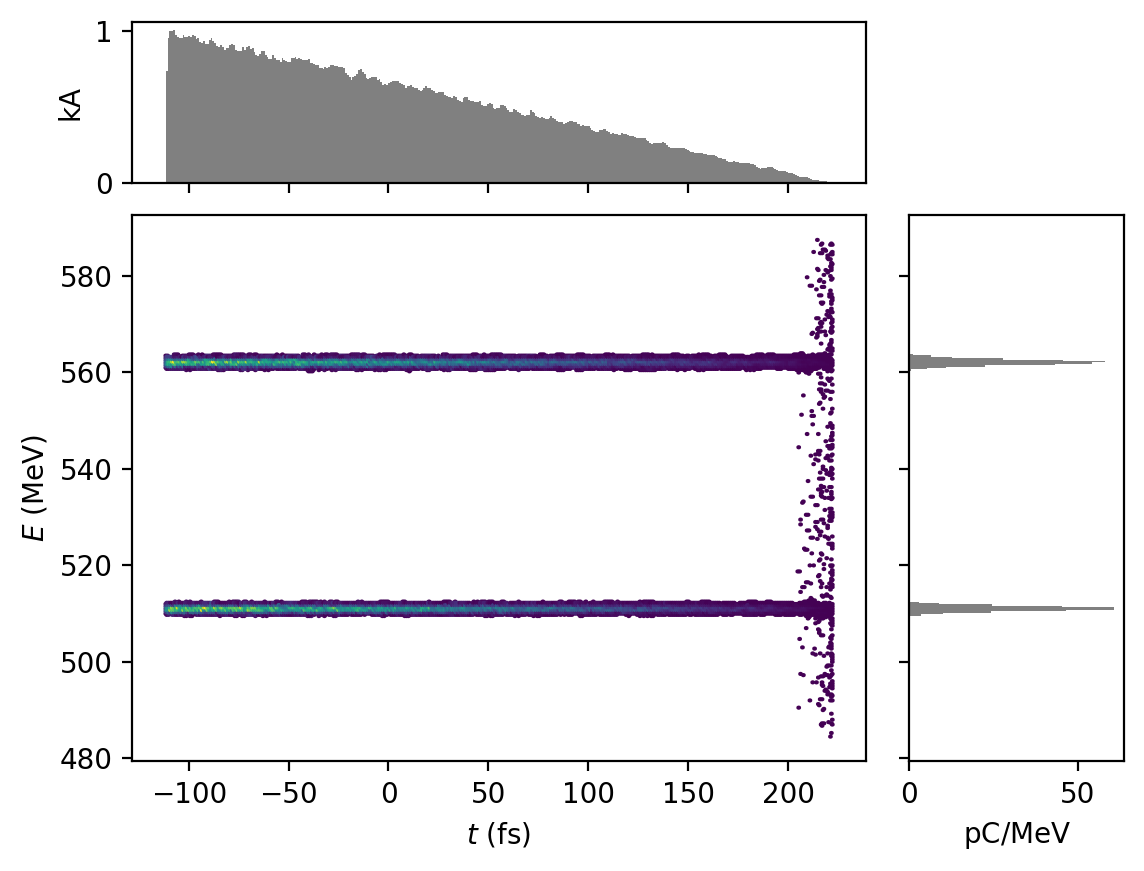

In [12]:
P2.drift_to_z()
P2.plot('t', 'energy')
P2

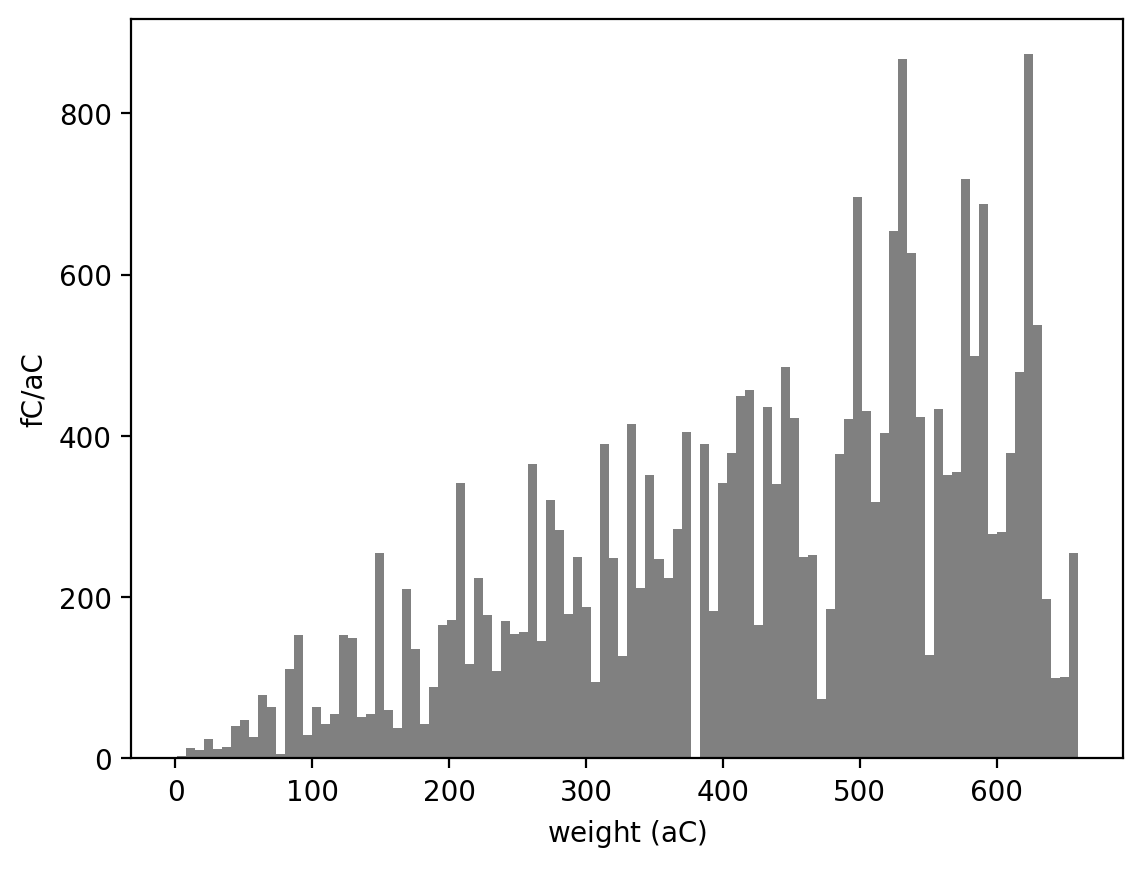

In [13]:
P2.plot('weight', bins=100)

Notice that `importdistribution` is filled in:

In [14]:
G1.input

{'main': [{'type': 'setup',
   'rootname': 'drift_test',
   'lattice': '/Users/chrisonian/Code/GitHub/lume-genesis/docs/examples/genesis4/data/genesis4_drift.lat',
   'beamline': 'LAT',
   'lambda0': 1e-07,
   'gamma0': 1000,
   'delz': 0.026,
   'seed': 123456,
   'npart': 512},
  {'type': 'time', 'slen': 0.0001, 'sample': 1},
  {'type': 'importdistribution',
   'file': '/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpyi0vl0mt/genesis4_importdistribution.h5',
   'charge': 1.667822143811237e-10},
  {'type': 'track', 'zstop': 1},
  {'type': 'write', 'beam': 'end'}]}